In [454]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import torch.nn as nn
import random
from scipy.stats import norm

In [455]:
from utils import *
from param_init import *
from exact_sol import *
from evaluation import *
from batching import *
from Adaptive_sampling import *
from Probability_algorithm import *


set_seed()

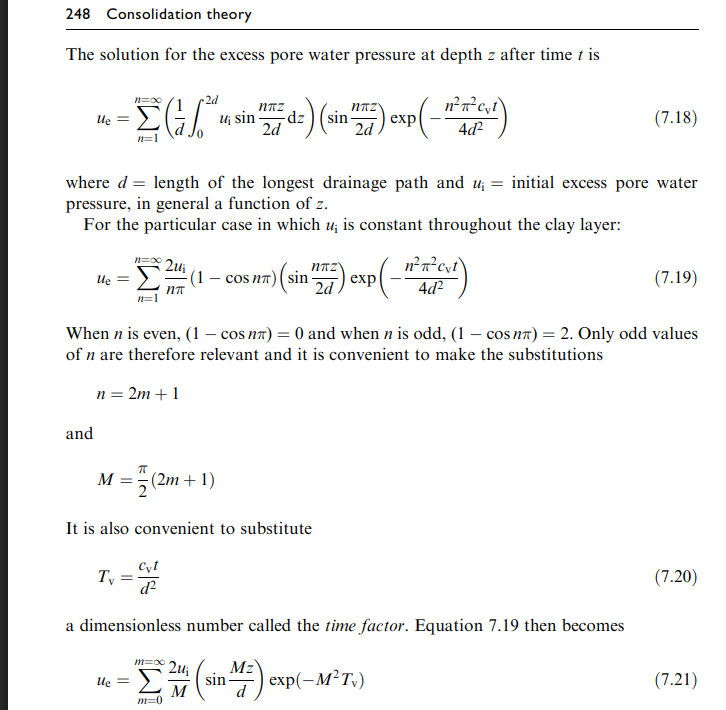

In [456]:
def analytical_excess_porepressure(time, z, delta_sigma, k, mv, H, terms=100):
    """
    Craig's Soil Mechanics, Seventh edition, Page 248
    Exact analytical solution for Terzaghi's 1D consolidation problem (double drainage).
    
    : time:         Time                                     (days)
    : z:            Depth                                    (m)
    : delta_sigma:  Applied vertical stress increment        (kPa)
    : k:            Coefficient of permeability              (m/day)
    : mv:           Coefficient of volume compressibility    (m^2/kN)
    : H:            Thickness of soil layer                  (m) 
    : terms:        Number of terms in the Fourier series
    : returns:      Excess pore water pressure u(z, t)       (kPa)
    """
    yw = 9.81         # unit weight of water (kN/m³)
    cv = k / (mv*yw)  # coefficient of consolidation (m²/day) 
    Tv= cv*time/H**2  # dimensionless time
    ue = 0.0
    for i in range (terms):
        M = np.pi/2* (2*i+1)
        ue+= 2*delta_sigma/M * np.sin(M*z/H) * np.exp(-M**2*Tv)
    return ue

In [457]:
def exact_degree_of_consolidation(time, k, mv, H, terms=100):
    """
    Craig's Soil Mechanics, Seventh edition, Page 250
    Exact analytical solution for Terzaghi's 1D consolidation problem (double drainage).
    
    : time:         Time                                     (days)
    : z:            Depth                                    (m)
    : delta_sigma:  Applied vertical stress increment        (kPa)
    : k:            Coefficient of permeability              (m/day)
    : mv:           Coefficient of volume compressibility    (m^2/kN)
    : H:            Thickness of soil layer                  (m) 
    : terms:        Number of terms in the Fourier series
    : returns:      Excess pore water pressure u(z, t)       (kPa)
    """
    cv = k / (9.81*mv)  # coefficient of consolidation (m²/s)
    Tv= cv*time/H**2 # dimensionless time
    U = 0.0
    for i in range(terms):
        M = np.pi/2* (2*i+1)
        U += 2/M**2 * np.exp(-M**2*Tv)
    return (1-U)

In [458]:
def exact_consolidation(U_t, delta_sigma, mv, H):
    """    
    : U_t:          Degree of consolidation                   (-)
    : delta_sigma:  Applied vertical stress increment        (kPa)
    : mv:           Coefficient of volume compressibility    (m^2/kN)
    : H:            Thickness of soil layer                  (m) 
    : returns:      
    """
    return delta_sigma * U_t * mv * H

In [459]:
from scipy.integrate import simpson 
def total_settlement(time, delta_sigma, k, mv, H, terms=100, num_points=1000):
    """
    Compute the total settlement at a given time by integrating effective stress
    calculated from excess pore pressure over the depth.

    : time:         Time (days)
    : delta_sigma:  Applied vertical stress increment (kPa)
    : k:            Coefficient of permeability (m/day)
    : mv:           Coefficient of volume compressibility (m²/kN)
    : H:            Thickness of the soil layer (m)
    : terms:        Number of Fourier terms
    : num_points:   Number of depth points to integrate over
    : returns:      Settlement s(t) in meters
    """
    z_vals = np.linspace(0, H, num_points)
    u_vals = np.array([analytical_excess_porepressure(time, z, delta_sigma, k, mv, H, terms) for z in z_vals])
    
    # Effective stress = delta_sigma - u
    effective_stress = delta_sigma - u_vals

    # Integrate effective stress over depth to get strain, then multiply by mv
    settlement = mv * simpson(effective_stress, x=z_vals)  # or np.trapz

    return settlement

In [ ]:
specs = {
    't': {'range': 10.0},  # Range of time (used for time sweep / normalization)

    'load': {
        'mean': 100.0,       # Applied vertical stress in kPa
        'std': 10.0,         # ~10% is realistic for construction load variability
        'lower_multiplier': -5,
        'upper_multiplier': 5
    },

    'k': {
        'mean': 7e-5,        # m/s (about 2.2 m/year – soft to medium clay)
        'std': 1.5e-5,       # ~20% std dev is common in lab tests for permeability
        'lower_multiplier': -5,
        'upper_multiplier': 5
    },

    'mv': {
        'mean': 1e-3,        # m²/kN (typical for Norwegian marine clay)
        'std': 2e-4,         # ~20% variation due to sample disturbance and strain level
        'lower_multiplier': -5,
        'upper_multiplier': 5
    },

    'H': {
        'mean': 10.0,        # m
        'std': 0.5,          # ~5% deviation due to stratigraphy or measurement error
        'lower_multiplier': -5,
        'upper_multiplier': 5
    }
}


# Run training pipeline
params=initialize_param(5000,distribute=['m','mu','k','y0','v0'],specs=specs, normalize=True)
#,'k','y0','v0'

# I only normalize the input parameters that are diustributed. That means that if training on all params, it expects 0 for mean. But if I change distribute to only 
# some params, I need to change the mean of the other params to 0 for it to be correct. 

In [465]:
t = 1.0  # time in days
z = 5.0  # depth in meters
delta_sigma = np.random.normal(specs['load']['mean'], specs['load']['std'])  # applied vertical stress increment in kPa
k = np.random.normal(specs['k']['mean'], specs['k']['std'])  # coefficient of permeability in m/day
mv = np.random.normal(specs['mv']['mean'], specs['mv']['std'])  # coefficient of volume compressibility in m²/kN
H = np.random.normal(specs['H']['mean'], specs['H']['std'])  # thickness of soil layer in m
terms = 100  # number of terms in the Fourier series

In [466]:
exact_porepressure = analytical_excess_porepressure(365, z, delta_sigma, k, mv, H, terms)
exact_degree = exact_degree_of_consolidation(365, k, mv, H, terms)
exact_consolidation_height = exact_consolidation(exact_degree, delta_sigma, mv, H)

print(f"Exact pore pressure: {exact_porepressure:.5f} kPa")
print(f"Exact degree of consolidation: {exact_degree:.5f} (-)")
print(f"Exact consolidation: {exact_consolidation_height:.18f} kPa")

total_settlement_value = total_settlement(365, delta_sigma, k, mv, H, terms=10)
print(total_settlement_value)

Exact pore pressure: 103.06745 kPa
Exact degree of consolidation: 0.15684 (-)
Exact consolidation: 0.200119246570618414 kPa
0.20011924657163088


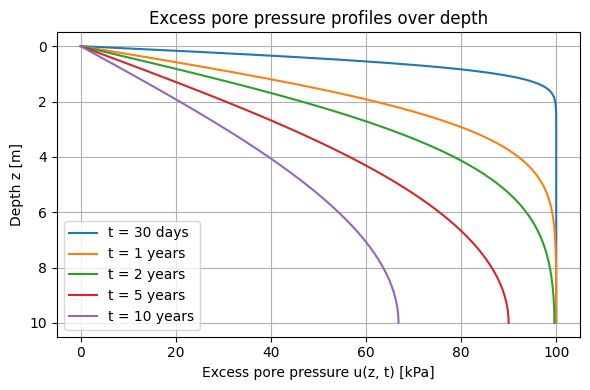

In [463]:
times = [30, 365, 2 * 365, 5 * 365, 10 * 365]  # Convert years to days
z_vals = np.linspace(0, H, 200)

# Create a new figure
plt.figure(figsize=(6, 4))

# Compute and plot pore pressure profiles over depth for each time
for i in range(len(times)):
    u_vals = [analytical_excess_porepressure(times[i], z, delta_sigma, k, mv, H) for z in z_vals]
    label = f"t = {times[i] // 365} years" if times[i] >= 365 else f"t = {times[i]} days"
    plt.plot(u_vals, z_vals, label=label)

# Add labels, title, and legend
plt.xlabel("Excess pore pressure u(z, t) [kPa]")
plt.ylabel("Depth z [m]")
plt.title("Excess pore pressure profiles over depth")
plt.grid(True)
plt.legend()
plt.gca().invert_yaxis()  # Invert the y-axis
plt.tight_layout()
plt.show()

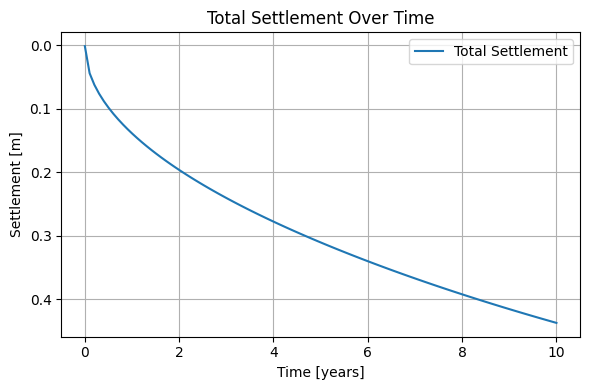

Total settlement: 0.43725 m


In [480]:
# Generate settlement values over time using exact_degree_of_consolidation and exact_consolidation
time_range = np.linspace(0, 10*365, 100)  # Time in days (0 to 10 years)
degree_of_consolidation_values = [exact_degree_of_consolidation(t, k, mv, H, terms=100) for t in time_range]
settlement_values = [exact_consolidation(U_t, delta_sigma, mv, H) for U_t in degree_of_consolidation_values]

# Create the plot
plt.figure(figsize=(6, 4))
plt.plot(time_range/365, settlement_values, label="Total Settlement")

# Add labels, title, and grid
plt.xlabel("Time [years]")
plt.ylabel("Settlement [m]")
plt.title("Total Settlement Over Time")
plt.grid(True)
plt.gca().invert_yaxis()  # Invert the y-axis
plt.legend()
plt.tight_layout()
plt.show()
print("Total settlement:", f"{settlement_values[-1]:.5f}", "m")

In [ ]:
t = 1.0  # time in days
z = 5.0  # depth in meters
delta_sigma = np.random.normal(specs['load']['mean'], specs['load']['std'])  # applied vertical stress increment in kPa
k = np.random.normal(specs['k']['mean'], specs['k']['std'])  # coefficient of permeability in m/day
mv = np.random.normal(specs['mv']['mean'], specs['mv']['std'])  # coefficient of volume compressibility in m²/kN
H = np.random.normal(specs['H']['mean'], specs['H']['std'])  # thickness of soil layer in m
terms = 100  # number of terms in the Fourier series